# Text Classification: Sentiment Analysis of Movie Reviews

This project focuses on building a text classification model to determine the sentiment (positive or negative) of movie reviews. The dataset consists of labeled movie reviews, making it a supervised learning task.

### Dataset Source:  
[Stanford Large Movie Review Dataset](http://ai.stanford.edu/~amaas/data/sentiment/)

### Objective: 
Develop and evaluate models that can accurately classify the sentiment of a given movie review based on its text content.

The following sections will cover data exploration, preprocessing, feature extraction, model training, evaluation, and result interpretation.

## 1. Data Setup and Importing Libraries

Begin by importing the necessary libraries and loading the movie reviews dataset into a pandas DataFrame.

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

###  Loading and Inspecting the Data

The movie reviews dataset is loaded into a pandas DataFrame for analysis. Displaying the first few rows provides a quick overview of the structure and contents of the data.

In [52]:
df = pd.read_csv('DATA/moviereviews.csv')

In [53]:
df.head()

,label,review
0,neg,how do films like mouse hunt get into theatres...
1,neg,some talented actresses are blessed with a dem...
2,pos,this has been an extraordinary year for austra...
3,pos,according to hollywood movies made in last few...
4,neg,my first press screening of 1998 and already i...


### Checking for Missing Values

Before proceeding with analysis and modeling, it is important to check the DataFrame for any missing values. Identifying and handling missing data ensures the integrity and reliability of subsequent steps.

In [54]:
df.isnull().sum()

label      0
review    35
dtype: int64

### Removing Reviews with Missing Values

Let's remove any reviews that contain missing (`NaN`) values from the DataFrame. This ensures the dataset only includes complete entries for further analysis and modeling.

In [55]:
df.dropna(inplace=True)
df.isnull().sum()

label     0
review    0
dtype: int64

#### Removing Blank String Reviews

Let's check for reviews that are blank strings (such as `""`, `"  "`, or strings containing only whitespace) in addition to `NaN` values. These entries do not provide any useful information for text classification, so we'll remove them from the DataFrame as well.

In [56]:
df['review'].str.isspace().sum()

27

In [57]:
df[df['review'].str.isspace()].head(8)

,label,review
57,neg,
71,pos,
147,pos,
151,pos,
283,pos,
307,pos,
313,neg,
323,pos,


In [58]:
df.drop(df[df['review'].str.isspace()].index, inplace=True)

#### Final Cleaned DataFrame

Let's inspect the final cleaned DataFrame now that all missing values and blank string reviews have been removed. The `info()` method provides an overview of the remaining entries and columns.

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1938 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   1938 non-null   object
 1   review  1938 non-null   object
dtypes: object(2)
memory usage: 45.4+ KB


**TASK: Confirm the value counts per label:**

#### Confirming Value Counts per Label

Let's check the distribution of labels in the dataset by confirming the value counts for each sentiment class. This helps ensure that the dataset is balanced and suitable for classification.

In [60]:
df['label'].value_counts()

label
neg    969
pos    969
Name: count, dtype: int64

## Exploratory Data Analysis

Let's explore the movie reviews dataset to better understand its structure, distribution, and key characteristics. This  will include review length distributions, sentiment balance, common bigrams, and vocabulary richness for each sentiment class.

#### Distribution of Review Lengths

Let's examine the distribution of review lengths (in words) and compare them across sentiment labels.

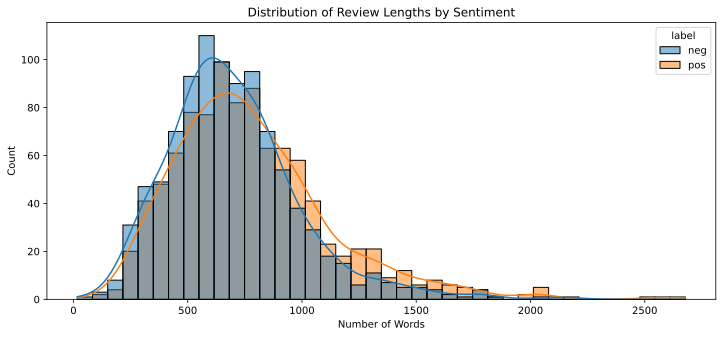

In [61]:
df['review_length'] = df['review'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12,5))
sns.histplot(data=df, x='review_length', hue='label', bins=40, kde=True)
plt.title('Distribution of Review Lengths by Sentiment')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.savefig('visualisations/review_length_distribution.svg')

#### Top Bigrams per Sentiment

Let's identify the most common two-word phrases (bigrams) in each sentiment class.

In [62]:
def get_top_ngrams(corpus, ngram_range=(2,2), n=None):
    vec = CountVectorizer(stop_words='english', ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

for sentiment in df['label'].unique():
    ngrams = get_top_ngrams(df[df['label']==sentiment]['review'].dropna().astype(str), ngram_range=(2,2), n=10)
    print(f"Top bigrams for {sentiment}:")
    for bigram, freq in ngrams:
        print(f"{bigram}: {freq}")
    print()

Top bigrams for neg:
special effects: 203
ve seen: 116
new york: 114
high school: 98
looks like: 89
year old: 84
bad movie: 78
bad guy: 72
look like: 66
van damme: 66

Top bigrams for pos:
special effects: 173
ve seen: 146
star wars: 132
new york: 130
year old: 100
science fiction: 95
star trek: 85
high school: 83
sci fi: 78
real life: 73



#### Vocabulary Richness

Let's compare the diversity of vocabulary used in positive and negative reviews.

In [63]:
def unique_word_count(texts):
    words = set()
    for review in texts:
        words.update(str(review).lower().split())
    return len(words)

for sentiment in df['label'].unique():
    count = unique_word_count(df[df['label']==sentiment]['review'])
    print(f"Unique words in {sentiment} reviews: {count}")

Unique words in neg reviews: 33736
Unique words in pos reviews: 36050


## EDA on Bag of Words

Can we use a `CountVectorizer` to identify the top 20 most frequent words (excluding English stop words) for each label type? This analysis helps reveal which words are most strongly associated with positive and negative reviews.  

In [46]:
def get_top_n_words(df, label_col, text_col, label_value, n=20):
    # Filter reviews for the given label and drop empty/whitespace-only reviews
    subset = df[df[label_col] == label_value][text_col].dropna().astype(str)
    subset = subset[subset.str.strip() != ""]
    if subset.empty:
        print(f"No valid reviews for label '{label_value}'.")
        return []
    # Initialize CountVectorizer with English stop words removed
    vec = CountVectorizer(stop_words='english')
    try:
        bag_of_words = vec.fit_transform(subset)
    except ValueError as e:
        print(f"Error for label '{label_value}':", e)
        return []
    # Sum up the word counts
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]


In [47]:
top_pos = get_top_n_words(df, label_col='label', text_col='review', label_value='pos', n=20)

pos_list = []
print("Top 20 words for positive reviews:")
for word, freq in top_pos:
    pos_list.append((word,freq))
print(pos_list)

Top 20 words for positive reviews:
[('film', 5002), ('movie', 2389), ('like', 1721), ('just', 1273), ('story', 1199), ('good', 1193), ('time', 1175), ('character', 1037), ('life', 1032), ('characters', 957), ('way', 864), ('films', 851), ('does', 828), ('best', 788), ('people', 769), ('make', 764), ('little', 751), ('really', 731), ('man', 728), ('new', 702)]


In [48]:
top_neg = get_top_n_words(df, label_col='label', text_col='review', label_value='neg', n=20)

neg_list = []
print("\nTop 20 words for negative reviews:")
for word, freq in top_neg:
    neg_list.append((word,freq))
print(neg_list)


Top 20 words for negative reviews:
[('film', 4063), ('movie', 3131), ('like', 1808), ('just', 1480), ('time', 1127), ('good', 1117), ('bad', 997), ('character', 926), ('story', 908), ('plot', 888), ('characters', 838), ('make', 813), ('really', 743), ('way', 734), ('little', 696), ('don', 683), ('does', 666), ('doesn', 648), ('action', 635), ('scene', 634)]


## Model Training

Let's fit the modeling pipeline to the training data. This step enables the model to learn patterns in the text reviews that distinguish between positive and negative sentiment.

### Training and Data

Let's split the data into features and labels (`X` and `y`) and perform a train/test split.

In [64]:
X = df['review']
y = df['label']

print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (1938,)
y shape: (1938,)


In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [66]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)


X_train shape: (1550,)
X_test shape: (388,)
y_train shape: (1550,)
y_test shape: (388,)


### Training a Model

Let's create a pipeline that transforms the raw text data into TF-IDF features and fits a supervised learning model. The pipeline will be trained on the training data. Any classifier can be used, such as Multinomial Naive Bayes or Logistic Regression.

In [72]:
pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')), ('clf', MultinomialNB())])

In [73]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('clf', MultinomialNB())])

In [74]:
pipe.steps

[('tfidf', TfidfVectorizer(stop_words='english')), ('clf', MultinomialNB())]

#### Hyperparameter Tuning for Multinomial Naive Bayes

Let's use grid search cross-validation to tune the `alpha` parameter of the Multinomial Naive Bayes classifier. This helps find the optimal level of smoothing for the model, potentially improving classification performance.

In [104]:
# Define the parameter grid for alpha
param_grid = {'clf__alpha': [0.1,0.25,0.3,0.5,1,2,3,4,5]}

# Set up GridSearchCV with the pipeline
grid = GridSearchCV(pipe, param_grid, cv=10, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("Best alpha:", grid.best_params_['clf__alpha'])
print("Best cross-validation accuracy:", grid.best_score_)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
Best alpha: 0.3
Best cross-validation accuracy: 0.803225806451613


## Model Evaluation

Let's evaluate the trained pipeline by generating a classification report and plotting a confusion matrix. These metrics will help assess the model's performance in classifying review sentiment.

In [90]:
preds = pipe.predict(X_test)

#### Classification Report

Let's review the classification report, which provides detailed metrics for each sentiment class, including precision, recall, f1-score, and support. This report offers a comprehensive summary of the model's ability to correctly classify positive and negative movie reviews, and helps identify any imbalances or areas for improvement.

In [91]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         neg       0.79      0.88      0.83       188
         pos       0.87      0.78      0.82       200

    accuracy                           0.82       388
   macro avg       0.83      0.83      0.82       388
weighted avg       0.83      0.82      0.82       388



#### Confusion Matrix

Let's visualize the confusion matrix to better understand the model's classification performance. The confusion matrix provides a detailed breakdown of correct and incorrect predictions for each sentiment class, highlighting areas where the model excels and where it may need improvement.

The matrix below displays the number of true positive, true negative, false positive, and false negative predictions. This visualization helps identify any bias towards a particular class and supports further analysis of model errors.

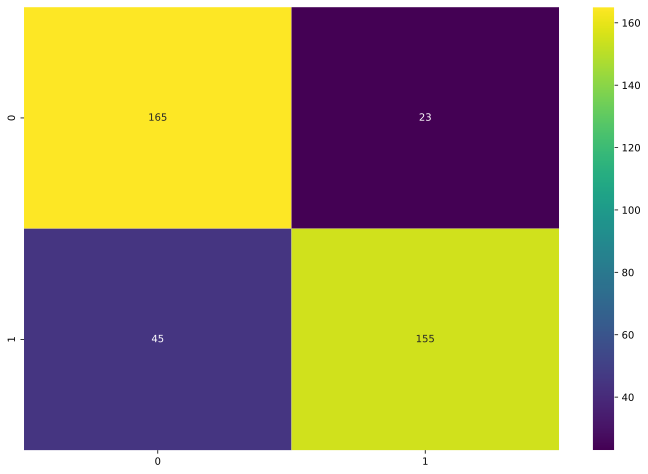

In [102]:
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, cmap='viridis',fmt='d')
plt.savefig('visualisations/confusion_matrix.svg')

## Conclusion

The text classification model demonstrated strong performance, achieving an overall accuracy of 82% on the test set. Both precision and recall were robust for each sentiment class, with the model showing slightly higher precision for positive reviews (0.87) and higher recall for negative reviews (0.88). The balanced f1-scores for both classes (0.82–0.83) indicate that the model is effective at distinguishing between positive and negative movie reviews.

These results suggest that the combination of TF-IDF feature extraction and Multinomial Naive Bayes is well-suited to this sentiment analysis task. The confusion matrix further confirms that the model makes relatively few misclassifications, and the classification report highlights its balanced performance across classes.

**Potential Improvements and Next Steps:**
- **Advanced Preprocessing:** Incorporate techniques such as lemmatization, stemming, or removal of rare words to further clean the text data.
- **Feature Engineering:** Experiment with additional features such as n-grams, sentiment lexicons, or part-of-speech tags.
- **Model Selection:** Compare the current approach with other classifiers (e.g., Logistic Regression, SVM, Random Forest) to potentially boost performance.
- **Hyperparameter Tuning:** Perform more extensive hyperparameter optimization, including tuning TF-IDF and model parameters.
- **Cross-Validation:** Use stratified k-fold cross-validation for a more robust estimate of model performance.
- **Error Analysis:** Examine misclassified reviews to identify patterns or edge cases that could inform further improvements.

Overall, this project demonstrates a solid approach to sentiment classification using classical machine learning techniques and provides a strong foundation for further exploration and enhancement.